# **Setup**

## Libraries

In [1]:
import argparse
import os
import sys
from functools import partial
from tqdm import tqdm
import json
from types import SimpleNamespace

import pyrootutils
import dgl
import dgl.function as fn
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import MeanMetric
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
from sklearn import metrics

import pandas as pd
import scipy.stats as st
from IPython.display import clear_output

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
# Simulate having cfg available by loading in hydra config as dict
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

## User Definition

In [3]:
user_net_id = os.getlogin()
home_path = '/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A'
if home_path not in sys.path:
    sys.path.append('/scratch/' + user_net_id + '/projects/NYU-Zillow-Capstone-2022-Team-A')

from src.datamodules.negative_sampler import NegativeSampler
from src.model.SAGE import SAGE

# **Modules**

## Graph Generation

In [4]:
def to_bidirected_with_reverse_mapping(g):
    """Makes a graph bidirectional, and returns a mapping array ``mapping`` where ``mapping[i]``
    is the reverse edge of edge ID ``i``. Does not work with graphs that have self-loops.
    """
    g_simple, mapping = dgl.to_simple(
        dgl.add_reverse_edges(g), return_counts="count", writeback_mapping=True
    )
    c = g_simple.edata["count"]
    num_edges = g.num_edges()
    mapping_offset = torch.zeros(g_simple.num_edges() + 1, dtype=g_simple.idtype)
    mapping_offset[1:] = c.cumsum(0)
    idx = mapping.argsort()
    idx_uniq = idx[mapping_offset[:-1]]
    reverse_idx = torch.where(
        idx_uniq >= num_edges, idx_uniq - num_edges, idx_uniq + num_edges
    )
    reverse_mapping = mapping[reverse_idx]
    # sanity check
    src1, dst1 = g_simple.edges()
    src2, dst2 = g_simple.find_edges(reverse_mapping)
    assert torch.equal(src1, dst2)
    assert torch.equal(src2, dst1)
    return g_simple, reverse_mapping


class NegativeSamplerTest(object):
    def __init__(self, g, k, max_img_id, keyword_as_src, neg_share=False):
        self.weights = g.in_degrees().float() ** 0.75
        self.k = k
        self.neg_share = neg_share
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src

    def __call__(self, g, eids):
        src, _ = g.find_edges(eids)
        if self.keyword_as_src == False:
            img_node_mask = src <= self.max_img_id
            src = src[img_node_mask]
        n = len(src)

        if self.neg_share and n % self.k == 0:
            dst = self.weights.multinomial(n, replacement=True)
            dst = dst.view(-1, 1, self.k).expand(-1, self.k, -1).flatten()
        else:
            dst = self.weights.multinomial(n * self.k, replacement=True)
            
        src = src.repeat_interleave(self.k)
        return src, dst

class DataModule(LightningDataModule):
    def __init__(
        self,
        csv_dataset_root,
        modal_node_ids_file,
        keyword_as_src=False,
        data_cpu=False,
        fan_out=[3],
        device="cpu",
        batch_size=1024,
        num_workers=4,
        force_reload=False,
    ):
        super().__init__()
        self.save_hyperparameters()
        dataset = dgl.data.CSVDataset(csv_dataset_root, force_reload=force_reload)
        g = dataset[0]
        g_bid, reverse_eids = to_bidirected_with_reverse_mapping(g)
        g_bid = g_bid.to(device)
        g = g.to(device)
        reverse_eids = reverse_eids.to(device)

        max_img_id = max(json.load(open(modal_node_ids_file, 'r'))['images'])

        train_nid = torch.nonzero(g_bid.ndata["train_mask"], as_tuple=True)[0].to(device)
        val_nid = torch.nonzero(g_bid.ndata["val_mask"], as_tuple=True)[0].to(device)
        test_nid = torch.nonzero(g_bid.ndata["test_mask"], as_tuple=True)[0].to(device)

        sampler = dgl.dataloading.NeighborSampler(fan_out)

        self.g = g
        self.g_bid = g_bid
        self.train_nid = train_nid
        self.val_nid = torch.cat((val_nid, test_nid))
        self.sampler = sampler
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.in_dim = g_bid.ndata["feat"].shape[1]
        self.reverse_eids = reverse_eids
        self.max_img_id = max_img_id
        self.keyword_as_src = keyword_as_src


    def train_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
            exclude='reverse_id',
            reverse_eids=self.reverse_eids,
            negative_sampler=NegativeSamplerTest(self.g, 1, self.max_img_id, self.keyword_as_src)
        )

        train_subgraph = self.g_bid.subgraph(self.train_nid)
        train_u, train_v = train_subgraph.edges()
        train_eids = train_subgraph.edata['_ID'][train_subgraph.edge_ids(train_u, train_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            train_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False
        )

    def val_dataloader(self):
        edge_sampler = dgl.dataloading.as_edge_prediction_sampler(
            self.sampler,
        )

        val_subgraph = self.g_bid.subgraph(self.val_nid)
        val_u, val_v = val_subgraph.edges()
        val_eids = val_subgraph.edata['_ID'][val_subgraph.edge_ids(val_u, val_v)]

        return dgl.dataloading.DataLoader(
            self.g_bid,
            val_eids,
            edge_sampler,
            device=self.device,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False
        )

## Model Infrastructure

In [5]:
def cosine_sim(a, b):
    a = F.normalize(a, p=2, dim=-1)
    b = F.normalize(b, p=2, dim=-1)

    try:
        return a @ b.T
    except:
        print('Matrix multiplication failed. Check dimensions.')

class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata["h"] = x
            edge_subgraph.ndata['h_norm'] = F.normalize(x, p=2, dim=-1)
            edge_subgraph.apply_edges(fn.u_dot_v("h_norm", "h_norm", "score"))
            return edge_subgraph.edata["score"]

class SAGELightning(LightningModule):
    def __init__(
        self,
        in_dim,
        h_dim,
        n_layers=3,
        activation=F.relu,
        dropout=0.7,
        sage_conv_method="mean",
        lr=0.005,
        batch_size=1024,
    ):
        super().__init__()
        self.module = SAGE(
            in_dim, h_dim, n_layers, activation, dropout, sage_conv_method
        )
        self.lr = lr
        self.predictor = ScorePredictor()
        self.batch_size = batch_size
        self.save_hyperparameters()

        self.train_loss = MeanMetric()
        self.mean_val_positive_score = MeanMetric()
    
    def forward(self, graph, blocks, x):
        self.module(graph, blocks, x)

    def training_step(self, batch, batch_idx):
        input_nodes, pos_graph, neg_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        neg_score = self.predictor(neg_graph, logits)

        score = torch.cat([pos_score, neg_score])
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        labels = torch.cat([pos_label, neg_label])
        loss = F.binary_cross_entropy_with_logits(score, labels)

        return loss

    def validation_step(self, batch, batch_idx):
        input_nodes, pos_graph, blocks = batch
        x = blocks[0].srcdata["feat"]
        logits = self.module(blocks, x)
        pos_score = self.predictor(pos_graph, logits)
        pos_label = torch.ones_like(pos_score)
        self.mean_val_positive_score(pos_score)

        self.log(
            "mean_val_positive_score",
            self.mean_val_positive_score,
            prog_bar=True,
            on_step=False,
            on_epoch=True,
            batch_size=self.batch_size,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# **Notebook Run - Preperation**

## Directory Definition

In [6]:
class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

root_path = pyrootutils.find_root(search_from='train_graphsage_explore.ipynb', indicator=".git")
print('Set WD location to', root_path)
pyrootutils.set_root(
    path=root_path,
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True
)

Set WD location to /scratch/alc9635/projects/NYU-Zillow-Capstone-2022-Team-A


## CUDA

In [7]:
try:
    if not torch.cuda.is_available():
        device = "cpu"
        print('No GPU available, using CPU')
    else:
        device = "cuda"
        print('Using GPU')
except:
    device = "cpu"
    print('No GPU available, using CPU')

Using GPU


# **Notebook Run**

## Select reconnection method

In [8]:
reconnection_method = 'scene'
#reconnection_method = 'cosine'
#reconnection_method = 'self'

## Graph Training

In [9]:
# Vanilla Graph Training
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))
org = 'zillow'
pre_connect_threshold = 0.975
connect_type = f'_images_{str(pre_connect_threshold).split(".")[-1]}' if reconnection_method == 'cosine' else ''

if org == 'coco':
    csv_dataset_root = cfg.data.coco_graph_root
elif org == 'zillow':
    csv_dataset_root = cfg.data.zillow_root + connect_type

modal_node_ids_file = os.path.join(csv_dataset_root,'modal_node_ids.json')
datamodule = DataModule(
    csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

model = SAGELightning(
    datamodule.in_dim,
    cfg.model.hidden_dim,
    n_layers=cfg.model.n_layers,
    batch_size=cfg.training.batch_size,
    lr=cfg.training.learning_rate
)

checkpoint_callback = ModelCheckpoint(
    monitor="mean_val_positive_score", save_top_k=1, mode="max"
)
trainer = Trainer(accelerator="gpu", max_epochs=cfg.training.n_epochs, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=datamodule)

Done loading data from cached files.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type           | Params
-----------------------------------------------------------
0 | module                  | SAGE           | 1.0 M 
1 | predictor               | ScorePredictor | 0     
2 | train_loss              | MeanMetric     | 0     
3 | mean_val_positive_score | MeanMetric     | 0     
-----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.198     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:135: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 160 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/lightning_lite/utilities/data.py:63: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurat

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 160 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 308/308 [00:02<00:00, 119.12it/s, loss=0.482, v_num=519, mean_val_positive_score=0.988]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 308/308 [00:02<00:00, 118.28it/s, loss=0.482, v_num=519, mean_val_positive_score=0.988]


## Reconnecting Train and Val Subgraphs

##### Initialize Val and Eval Subgraphs

In [10]:
# Step 1: Initialize val and eval subgraph
val_subgraph = datamodule.g_bid.subgraph(datamodule.val_nid)
eval_subgraph = datamodule.g_bid.subgraph(datamodule.train_nid)

##### Combine Nodes Only (No Edges)

In [11]:
val_img_node_idxs = (val_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
val_img_embeds = val_subgraph.ndata['feat'][val_img_node_idxs]
val_img_node_ids = val_subgraph.ndata['_ID'][val_img_node_idxs]

print('number of val img nodes:', len(val_img_node_ids))
print('number of train img nodes:', len(eval_subgraph.nodes()))

val_nodes_data = {'train_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'val_mask': torch.ones(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'test_mask': torch.zeros(len(val_img_node_ids), dtype=torch.uint8).to(device),
                  'ntype': torch.zeros(len(val_img_node_ids), dtype=torch.int64).to(device),
                  'feat': val_img_embeds.to(device),
                  '_ID': val_img_node_ids}

eval_subgraph.add_nodes(num=len(val_img_node_ids), data=val_nodes_data)

number of val img nodes: 24784
number of train img nodes: 59486


##### Identify Node Pairs as Potential Edges

Method: Cosine

In [12]:
################################################
## Reconnection Type : COSINE ##################
## Finding Img-Any Training Node Pairs #########
################################################

if reconnection_method == 'cosine':
    # Step 3: Identify image node pairs as edges

    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((eval_subgraph.ndata['ntype'] == 1)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_val_img_embeds = eval_subgraph.ndata['feat'][eval_val_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_val_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_val_img_embeds, eval_train_kw_embeds)

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        # get val img to train img matches
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        # get val img to train keyword matches
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        matches.append(eval_train_node_id_matches.tolist())

    matches_per_img = [len(match_list) for match_list in matches]
    print('match stats:')
    print(f'min matches: {np.min(matches_per_img)}')
    print(f'max matches: {np.max(matches_per_img)}')
    print(f'avg matches: {np.mean(matches_per_img)}')
    print(f'std matches: {np.std(matches_per_img)}')
    print(f'total new edges to add: {sum(matches_per_img)*2}')

Method: Scene

In [13]:
###############################
## Reconnection Type : SCENE ##
##   Finding Img-Img Pairs   ##
###############################

if reconnection_method == 'scene':
    # Step 3: Identify image and scene node pairs as edges

    eval_train_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['train_mask']==1)).nonzero().squeeze()

    eval_val_img_node_idxs = ((eval_subgraph.ndata['ntype'] == 0)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()
    eval_val_scene_node_idxs = ((eval_subgraph.ndata['ntype'] == 2)&(eval_subgraph.ndata['val_mask']==1)).nonzero().squeeze()

    eval_train_img_ids = eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_val_img_ids = eval_subgraph.ndata['_ID'][eval_val_img_node_idxs]
    eval_val_scene_ids = eval_subgraph.ndata['_ID'][eval_val_scene_node_idxs]

    def get_scene_edges(node_id, input_graph=datamodule.g_bid, eval_train_scene_ids=eval_train_scene_ids):
        u_node, v_node = input_graph.edges()

        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)

        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)
        for elem in eval_train_scene_ids:
            indices = indices | (all_edge_ids == elem)  

        intersection = all_edge_ids[indices] 

        return torch.unique(intersection)

##### Collect Edges for Eval Subgraph

In [14]:
if reconnection_method == 'cosine':

    # Step 4: Add the edges to eval_subgraph

    u = []
    v = []

    for i in range(len(matches)):
        val_img_node = eval_val_img_node_idxs[i].item()
        train_matches = matches[i]
        for node_id in train_matches:
            train_img_node = node_id
            # Add bidirectional edge for each match
            u += [val_img_node, train_img_node]
            v += [train_img_node, val_img_node]

In [15]:
if reconnection_method == 'scene':
    
    ## every eval-validation image:
    ##### find all eval-train scenes it is connected to in the eval_subgraph
    ##### connect the image-scene 

    u = []
    v = []

    for eval_val_img_id in tqdm(eval_val_img_ids):
        matching_eval_train_scenes = get_scene_edges(eval_val_img_id, 
                                                    input_graph=datamodule.g_bid, 
                                                    eval_train_scene_ids=eval_train_scene_ids)
        
        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u += [eval_val_img_id.item(), scene.item()]
                v += [scene.item(), eval_val_img_id.item()]

  0%|          | 0/24784 [00:00<?, ?it/s]/tmp/ipykernel_5979/1343416575.py:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  intersection = all_edge_ids[indices]
100%|██████████| 24784/24784 [00:29<00:00, 835.34it/s] 


#### Add Edges to Eval Subgraph

In [16]:
if reconnection_method == 'cosine' or reconnection_method == 'scene':
    edge_data = {'_ID': torch.arange(torch.max(eval_subgraph.edata['_ID'])+1, torch.max(eval_subgraph.edata['_ID'])+1+len(u), dtype=torch.int64).to(device)}
    eval_subgraph.add_edges(torch.LongTensor(u).to(device), torch.LongTensor(v).to(device), data=edge_data)
eval_subgraph = eval_subgraph.add_self_loop()

##### Convert DGL Graph into GraphSAGE Compatible Object

In [17]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_eval, v_eval = eval_subgraph.edges()
eval_subgraph_eids = eval_subgraph.edge_ids(u_eval, v_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[10, 25]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(eval_subgraph.edges()[0])

def eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

eval_dl = eval_dataloader(eval_subgraph, layer_sampler, batch_size, eval_subgraph_eids)

##### Run GraphSAGE Inferences

In [18]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    inputs, edge_subgraph, blocks = batch
    
x = blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(blocks, x)

eval_subgraph.ndata['feat_pred_norm'] = F.normalize(logits, p=2, dim=-1)

##### Extract Validation Image Features and Keyword Features

In [19]:
# Step 7: Extract validation image features and keyword features for 
eval_val_img_node_ids = ((eval_subgraph.ndata['val_mask']==1)&(eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

# Post-GraphSAGE embeddings
eval_val_img_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_val_img_node_ids]
eval_keyword_feat_sage = eval_subgraph.ndata['feat_pred_norm'][eval_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_subgraph.ndata['feat_norm'] = F.normalize(eval_subgraph.ndata['feat'], p=2, dim=-1)
eval_val_img_feat_clip = eval_subgraph.ndata['feat_norm'][eval_val_img_node_ids]
eval_keyword_feat_clip = eval_subgraph.ndata['feat_norm'][eval_keyword_node_ids]

##### Compute Cosine Similarities

In [20]:
verbose = False

# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1

val_sage_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_sage.cpu().detach().numpy(),
                                                          eval_val_img_feat_sage.cpu().detach().numpy())
val_clip_link_scores = metrics.pairwise.cosine_similarity(eval_keyword_feat_clip.cpu().detach().numpy(),
                                                          eval_val_img_feat_clip.cpu().detach().numpy())

if verbose:
    print('means:')
    print('sage:', np.mean(val_sage_link_scores))
    print('clip:', np.mean(val_clip_link_scores))
    print('mins:')
    print('sage:', np.min(val_sage_link_scores))
    print('clip:', np.min(val_clip_link_scores))
    print('maxs:')
    print('sage:', np.max(val_sage_link_scores))
    print('clip:', np.max(val_clip_link_scores))
    print('stds:')
    print('sage:', np.std(val_sage_link_scores))
    print('clip:', np.std(val_clip_link_scores))

##### Predict and Compute Precision/Recall/Accuracy

In [21]:
# Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
# Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
val_img_indices = (val_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
val_keyword_indices = (val_subgraph.ndata['ntype']==1).nonzero().cpu().reshape(-1, 1)

val_adj_matrix = val_subgraph.adjacency_matrix().to_dense().numpy()
val_adj_matrix = val_adj_matrix[val_keyword_indices, val_img_indices]


# Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
pred_thresholds = np.linspace(0.1, 0.5, 30)
sage_clip_metrics = pd.DataFrame()

for pred_threshold in pred_thresholds:
    val_sage_link_predictions = (val_sage_link_scores > pred_threshold).astype(int)
    val_clip_link_predictions = (val_clip_link_scores > pred_threshold).astype(int)

    results_dict = {'sage': {'tp': np.empty(len(val_sage_link_predictions)),
                             'fp': np.empty(len(val_sage_link_predictions)),
                             'fn': np.empty(len(val_sage_link_predictions)),
                             'actual_p': np.empty(len(val_sage_link_predictions)),
                             'precision': np.empty(len(val_sage_link_predictions)),
                             'recall': np.empty(len(val_sage_link_predictions))},
                    'clip': {'tp': np.empty(len(val_sage_link_predictions)),
                             'fp': np.empty(len(val_sage_link_predictions)),
                             'fn': np.empty(len(val_sage_link_predictions)),
                             'actual_p': np.empty(len(val_sage_link_predictions)),
                             'precision': np.empty(len(val_sage_link_predictions)),
                             'recall': np.empty(len(val_sage_link_predictions))}}

    weights = np.empty(len(val_sage_link_predictions))

    for i in range(len(val_sage_link_predictions)):
        sage_tp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
        sage_fp = np.sum(((val_sage_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
        sage_fn = np.sum(((val_sage_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
        sage_p = np.sum(val_sage_link_predictions[i])
        
        clip_tp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==1)))
        clip_fp = np.sum(((val_clip_link_predictions[i]==1)&(val_adj_matrix[i]==0)))
        clip_fn = np.sum(((val_clip_link_predictions[i]==0)&(val_adj_matrix[i]==1)))
        clip_p = np.sum(val_clip_link_predictions[i])

        true_p = np.sum(val_adj_matrix[i])
        
        results_dict['sage']['tp'][i] = sage_tp
        results_dict['sage']['fp'][i] = sage_fp
        results_dict['sage']['fn'][i] = sage_fn
        results_dict['sage']['actual_p'][i] = true_p
        results_dict['sage']['precision'][i] = sage_tp / sage_p if sage_p > 0 else 0
        results_dict['sage']['recall'][i] = sage_tp / true_p if true_p > 0 else 0

        results_dict['clip']['tp'][i] = clip_tp
        results_dict['clip']['fp'][i] = clip_fp
        results_dict['clip']['fn'][i] = clip_fn
        results_dict['clip']['actual_p'][i] = true_p
        results_dict['clip']['precision'][i] = clip_tp / clip_p if clip_p > 0 else 0
        results_dict['clip']['recall'][i] = clip_tp / true_p if true_p > 0 else 0

        weights[i] = true_p

    weights /= np.sum(weights)

    for method in results_dict.keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[method]:
            if metric == 'precision' or metric == 'recall':
                row[f'{metric}_micro'] = np.mean(results_dict[method][metric]*weights)
                row[f'{metric}_macro'] = np.mean(results_dict[method][metric])
            else:
                row[metric] = np.mean(results_dict[method][metric])
        sage_clip_metrics = pd.concat([sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

sage_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='sage')]
clip_metrics = sage_clip_metrics[(sage_clip_metrics['method']=='clip')]

In [22]:
print('Best SAGE metrics: ')
print('Precision, Recall at Max Recall:\n', sage_metrics[sage_metrics['recall_macro']==sage_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', sage_metrics[sage_metrics['precision_macro']==sage_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

print('Best CLIP metrics: ')
print('Precision, Recall at Max Recall:\n', clip_metrics[clip_metrics['recall_macro']==clip_metrics['recall_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])
print('Precision, Recall at Max Precision:\n', clip_metrics[clip_metrics['precision_macro']==clip_metrics['precision_macro'].max()][['threshold', 'precision_macro', 'recall_macro']].iloc[0,:])

Best SAGE metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000422
recall_macro       0.740801
Name: 0, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.265517
precision_macro    0.000422
recall_macro       0.713765
Name: 24, dtype: float64
Best CLIP metrics: 
Precision, Recall at Max Recall:
 threshold          0.100000
precision_macro    0.000422
recall_macro       0.751958
Name: 1, dtype: float64
Precision, Recall at Max Precision:
 threshold          0.417241
precision_macro    0.011897
recall_macro       0.185659
Name: 47, dtype: float64


##### Generate Plots

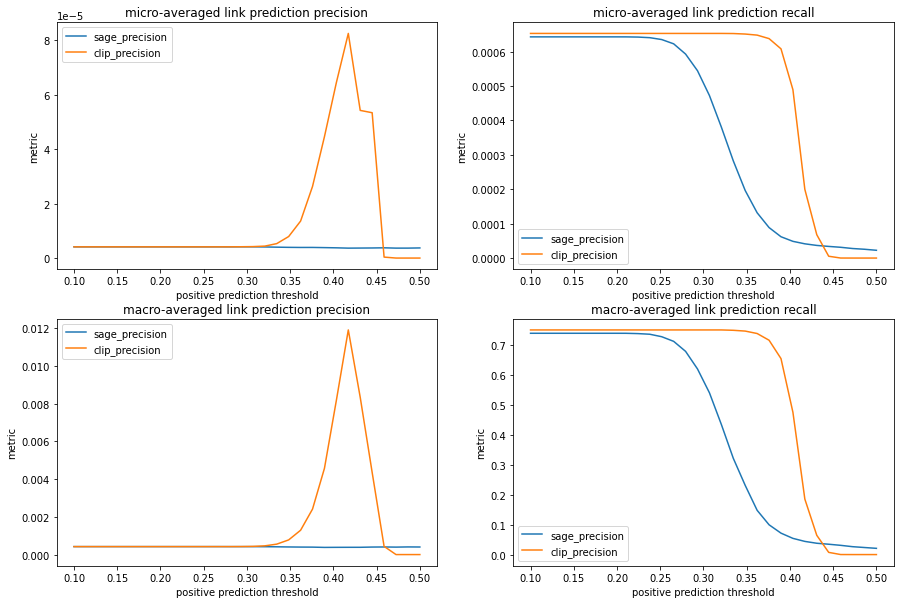

In [23]:
import matplotlib.pyplot as plt

sage_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
clip_micro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
sage_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
clip_macro_threshold_metrics = sage_clip_metrics[sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(sage_clip_metrics[sage_clip_metrics['method']==method]['threshold'], 
                    sage_clip_metrics[sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
plt.show()


# Evaluation on Holdout Set
### (Zillow Only)


In [24]:
cfg = NestedNamespace(yaml.load(open('conf/config.yaml'), Loader=Loader))
val_csv_dataset_root = cfg.graph.zillow_val.graph_dir

test_modal_node_ids_file = os.path.join(val_csv_dataset_root,'modal_node_ids.json')
test_new_old_node_id_mapping_file = os.path.join(val_csv_dataset_root,'new_old_node_id_mapping.json')
test_datamodule = DataModule(
    val_csv_dataset_root, 
    modal_node_ids_file, 
    keyword_as_src=False, 
    device=device, 
    batch_size=cfg.training.batch_size, 
    force_reload=False
)

Done loading data from cached files.


In [25]:
test_subgraph = test_datamodule.g_bid
test_eval_subgraph = datamodule.g_bid.subgraph(datamodule.g_bid.nodes())
test_eval_subgraph.ndata['test_mask'] = torch.zeros(len(test_eval_subgraph.nodes()), dtype=torch.uint8).to(device)
print(len(test_eval_subgraph.ndata['test_mask']))

test_img_node_idxs = (test_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
test_img_embeds = test_subgraph.ndata['feat'][test_img_node_idxs]
test_img_node_ids = test_subgraph.nodes()[test_img_node_idxs] + torch.max(test_eval_subgraph.nodes()) + 1

print('number of test img nodes:', len(test_img_node_ids))
print('number of "train" img nodes:', len(test_eval_subgraph.nodes()))

test_nodes_data = {'train_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'val_mask': torch.zeros(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'test_mask': torch.ones(len(test_img_node_ids), dtype=torch.uint8).to(device),
                   'ntype': torch.zeros(len(test_img_node_ids), dtype=torch.int64).to(device),
                   'feat': test_img_embeds.to(device),
                   '_ID': test_img_node_ids}

test_eval_subgraph.add_nodes(num=len(test_img_node_ids), data=test_nodes_data)

84270
number of test img nodes: 9206
number of "train" img nodes: 84270


In [26]:
# get node ID to hash ID mappings to find in-vocabulary keywords and scenes from test dataset

test_keyword_ids = test_subgraph.nodes()[(test_subgraph.ndata['ntype']==1).nonzero().squeeze()].cpu().detach().tolist()
test_new_old_node_id_mapping = json.load(open(test_new_old_node_id_mapping_file, 'r'))
test_old_new_node_id_mapping = {v: k for k, v in test_new_old_node_id_mapping.items()}

train_new_old_node_id_mapping_file = os.path.join(csv_dataset_root,'new_old_node_id_mapping.json')
train_new_old_node_id_mapping = json.load(open(train_new_old_node_id_mapping_file, 'r'))
train_old_new_node_id_mapping = {v: k for k, v in train_new_old_node_id_mapping.items()}


if reconnection_method == 'cosine':
    # Step 3: Identify image node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_kw_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 1)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    
    eval_train_img_embeds = test_eval_subgraph.ndata['feat'][eval_train_img_node_idxs]
    eval_train_kw_embeds = test_eval_subgraph.ndata['feat'][eval_train_kw_node_idxs]
    eval_test_img_embeds = test_eval_subgraph.ndata['feat'][eval_test_img_node_idxs]

    cosine_sims_img_matrix = cosine_sim(eval_test_img_embeds, eval_train_img_embeds)
    cosine_sims_img_kw_matrix = cosine_sim(eval_test_img_embeds, eval_train_kw_embeds)
    print(eval_test_img_embeds.size())
    print(cosine_sims_img_matrix.size())

    img_sim_threshold = 0.98
    img_img_k = 5
    img_kw_k = 5
            
    test_eval_matches = []
    for i in tqdm(range(cosine_sims_img_matrix.size(0)), desc='computing image-image matches'):
        # get val img to train img matches
        eval_train_img_node_id_matches = eval_train_img_node_idxs[(cosine_sims_img_matrix[i]>img_sim_threshold)]

        if len(eval_train_img_node_id_matches) < img_img_k:
            img_matches, img_match_indices = torch.topk(cosine_sims_img_matrix[i], img_img_k)
            eval_train_img_node_id_matches = eval_train_img_node_idxs[img_match_indices]
        
        # get val img to train keyword matches
        kw_matches, kw_match_indices = torch.topk(cosine_sims_img_kw_matrix[i], img_kw_k)
        
        eval_train_kw_node_id_matches = eval_train_kw_node_idxs[kw_match_indices]

        eval_train_node_id_matches = torch.cat((eval_train_img_node_id_matches, eval_train_kw_node_id_matches))
        matches.append(eval_train_node_id_matches.tolist())

    test_matches_per_img = [len(match_list) for match_list in test_eval_matches]


if reconnection_method == 'scene':
    # Step 3: Identify image and scene node pairs as edges

    eval_train_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()
    eval_train_scene_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 2)&(test_eval_subgraph.ndata['test_mask']==0)).nonzero().squeeze()

    eval_test_img_node_idxs = ((test_eval_subgraph.ndata['ntype'] == 0)&(test_eval_subgraph.ndata['test_mask']==1)).nonzero().squeeze()
    
    eval_train_img_ids = test_eval_subgraph.ndata['_ID'][eval_train_img_node_idxs]
    eval_train_scene_ids = test_eval_subgraph.ndata['_ID'][eval_train_scene_node_idxs]

    eval_test_img_ids = test_eval_subgraph.ndata['_ID'][eval_test_img_node_idxs]
    test_img_ids = (test_subgraph.ndata['ntype'] == 0).nonzero().squeeze()
    test_scene_ids = (test_subgraph.ndata['ntype'] == 2).nonzero().squeeze()

    train_scene_hashes = [train_new_old_node_id_mapping[str(key.item())] for key in eval_train_scene_ids]
    test_scene_hashes = [test_new_old_node_id_mapping[str(key.item())] for key in test_scene_ids]
    test_train_scene_node_mapper = {}

    for i in range(len(test_scene_hashes)):
        if test_scene_hashes[i] in train_scene_hashes:
            test_node_id = test_old_new_node_id_mapping[str(test_scene_hashes[i])]
            train_node_id = train_old_new_node_id_mapping[str(test_scene_hashes[i])]
            test_train_scene_node_mapper[int(test_node_id)] = int(train_node_id)

    def get_scene_edges_test(node_id, eval_graph, test_graph, eval_train_scene_ids, eval_test_scene_ids,
                             test_train_scene_node_mapper):
                             
        u_node, v_node = test_graph.edges()
        u_node_edge_idxs = torch.nonzero(node_id == u_node)
        v_ids = v_node[u_node_edge_idxs]

        v_node_edge_idxs = torch.nonzero(node_id == v_node)
        u_ids = u_node[v_node_edge_idxs]

        all_edge_ids = torch.cat([u_ids, v_ids], dim=0)
        
        indices = torch.zeros_like(all_edge_ids, dtype = torch.uint8, device = device)
        for elem in eval_test_scene_ids:
            indices = indices | (all_edge_ids == elem)

        intersection = [node for node in all_edge_ids[indices].cpu().detach().tolist() if node in list(test_train_scene_node_mapper.keys())]
        intersection_mapped = torch.LongTensor([test_train_scene_node_mapper[key] for key in intersection])
        
        return torch.unique(intersection_mapped)

In [27]:
if reconnection_method == 'cosine':

    # Step 4: Add the edges to eval_subgraph

    u_test = []
    v_test = []

    for i in range(len(test_eval_matches)):
        test_img_node = eval_test_img_node_idxs[i].item()
        train_matches = test_eval_matches[i]
        for node_id in train_matches:
            train_img_node = node_id
            # Add bidirectional edge for each match
            u_test += [test_img_node, train_img_node]
            v_test += [train_img_node, test_img_node]

if reconnection_method == 'scene':
    
    ## every eval-validation image:
    ##### find all eval-train scenes it is connected to in the eval_subgraph
    ##### connect the image-scene 

    u_test = []
    v_test = []

    for test_img_id in tqdm(test_img_ids):
        matching_eval_train_scenes = get_scene_edges_test(test_img_id, test_eval_subgraph, test_subgraph, 
                                                          eval_train_scene_ids, test_scene_ids, test_train_scene_node_mapper)

        if matching_eval_train_scenes.size(dim=0) > 0:
            for scene in matching_eval_train_scenes:
                u_test += [test_img_id.item(), scene.item()]
                v_test += [scene.item(), test_img_id.item()]

if reconnection_method == 'cosine' or reconnection_method == 'scene':
    test_edge_data = {'_ID': torch.arange(torch.max(test_eval_subgraph.edata['_ID'])+1, torch.max(test_eval_subgraph.edata['_ID'])+1+len(u_test), dtype=torch.int64).to(device)}
    test_eval_subgraph.add_edges(torch.LongTensor(u_test).to(device), torch.LongTensor(v_test).to(device), data=test_edge_data)
test_eval_subgraph = test_eval_subgraph.add_self_loop()

  0%|          | 0/9206 [00:00<?, ?it/s]/tmp/ipykernel_5979/4081445829.py:93: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  intersection = [node for node in all_edge_ids[indices].cpu().detach().tolist() if node in list(test_train_scene_node_mapper.keys())]
100%|██████████| 9206/9206 [00:06<00:00, 1350.88it/s]


In [28]:
# Step 5: Turn DGL graph into DataLoader object for GraphSAGE forward inference

u_test_eval, v_test_eval = test_eval_subgraph.edges()
test_eval_subgraph_eids = test_eval_subgraph.edge_ids(u_test_eval, v_test_eval)
layer_sampler = dgl.dataloading.NeighborSampler(fanouts=[10, 25]) # During message passing between GNN layers, each node accept messages from a maximum of 25 incoming nodes
batch_size = len(test_eval_subgraph_eids)

def test_eval_dataloader(g, layer_sampler, batch_size, eids):
    edge_sampler = dgl.dataloading.as_edge_prediction_sampler(layer_sampler)

    return dgl.dataloading.DataLoader(
        g,
        eids,
        edge_sampler,
        device=device,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
        # num_workers=self.num_workers,
    )

test_eval_dl = test_eval_dataloader(test_eval_subgraph, layer_sampler, batch_size, test_eval_subgraph_eids)

In [29]:
# Step 6: Run graphSAGE forward inference over entire val_subgraph message flow graph (MFG)

for batch in test_eval_dl:
    # This loop only runs once b/c batch_size = number of total edges in train_val_subgraph - we only need it to get "blocks"
    test_inputs, test_edge_subgraph, test_blocks = batch
    
x = test_blocks[0].srcdata["feat"]
model = model.to(device)
logits = model.module(test_blocks, x)

test_eval_subgraph.ndata['feat_pred'] = logits

In [30]:
# Step 7: Extract validation image features and keyword features for 
eval_test_img_node_ids = ((test_eval_subgraph.ndata['test_mask']==1)&(test_eval_subgraph.ndata['ntype']==0)).nonzero().squeeze()
eval_keyword_node_ids = ((test_eval_subgraph.ndata['ntype']==1)).nonzero().squeeze()

test_keyword_hashes = [test_new_old_node_id_mapping[str(key)] for key in test_keyword_ids]
train_keyword_hashes = [train_new_old_node_id_mapping[str(key.item())] for key in eval_keyword_node_ids]

train_overlap_ids = []
for i in range(len(train_keyword_hashes)):
    if train_keyword_hashes[i] in test_keyword_hashes:
        train_overlap_ids.append(eval_keyword_node_ids[i])
eval_test_keyword_node_ids = torch.LongTensor(train_overlap_ids)

test_overlap_ids = []
for i in range(len(test_keyword_hashes)):
    if test_keyword_hashes[i] in train_keyword_hashes:
        test_overlap_ids.append(test_keyword_ids[i])
test_keyword_node_ids = torch.LongTensor(test_overlap_ids)

# Post-GraphSAGE embeddings
eval_test_img_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_img_node_ids]
eval_keyword_feat_sage = test_eval_subgraph.ndata['feat_pred'][eval_test_keyword_node_ids]

# Original CLIP embeddings before GraphSAGE forward method
eval_test_img_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_img_node_ids]
eval_keyword_feat_clip = test_eval_subgraph.ndata['feat'][eval_test_keyword_node_ids]

In [31]:
verbose = False

# Step 8: Compute cosine similarities between validation images and keywords to get "link scores" between 0 and 1

test_sage_link_scores = cosine_sim(eval_keyword_feat_sage, eval_test_img_feat_sage).cpu().detach().numpy()
test_clip_link_scores = cosine_sim(eval_keyword_feat_clip, eval_test_img_feat_clip).cpu().detach().numpy()

if verbose:
    print('means:')
    print('sage:', np.mean(val_sage_link_scores))
    print('clip:', np.mean(val_clip_link_scores))
    print('mins:')
    print('sage:', np.min(val_sage_link_scores))
    print('clip:', np.min(val_clip_link_scores))
    print('maxs:')
    print('sage:', np.max(val_sage_link_scores))
    print('clip:', np.max(val_clip_link_scores))
    print('stds:')
    print('sage:', np.std(val_sage_link_scores))
    print('clip:', np.std(val_clip_link_scores))

In [32]:
# Step 9: Get true labels for each keyword from validation subgraph adjacency matrix
# Adjacency matrix needs to be sub-setted such that rows correspond only to image nodes and columns correspond only to keyword nodes
test_img_indices = (test_subgraph.ndata['ntype']==0).nonzero().cpu().reshape(1, -1)
test_keyword_indices = test_keyword_node_ids.reshape(-1, 1)

test_adj_matrix = test_subgraph.adjacency_matrix().to_dense().numpy()
test_adj_matrix = test_adj_matrix[test_keyword_indices, test_img_indices]

method_link_scores = {'sage': test_sage_link_scores, 'clip': test_clip_link_scores}

# Step 10: Make predictions based on prediction threshold and get precision, recall, and accuracy 
pred_thresholds = np.linspace(0.1, 0.9, 50)
test_sage_clip_metrics = pd.DataFrame()
results_dict = {threshold: {} for threshold in pred_thresholds}

for pred_threshold in pred_thresholds:
    results_dict[pred_threshold] = {'sage': {}, 'clip': {}}

    for method in method_link_scores:
        method_link_predictions = (method_link_scores[method] > pred_threshold).astype(int)
        n_keywords = len(method_link_scores[method])
        for metric in ['tp', 'fp', 'fn', 'actual_p', 'precision', 'recall', 'f1']:
            results_dict[pred_threshold][method][metric] = np.empty(n_keywords)
        weights = np.empty(n_keywords)
        
        for i in range(n_keywords):
            all_p = np.sum(test_adj_matrix[i])
            all_p_pred = np.sum(method_link_predictions[i])
            results_dict[pred_threshold][method]['tp'][i] = np.sum((method_link_predictions[i]==1)&(test_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['fp'][i] = np.sum((method_link_predictions[i]==1)&(test_adj_matrix[i]==0))
            results_dict[pred_threshold][method]['fn'][i] = np.sum((method_link_predictions[i]==0)&(test_adj_matrix[i]==1))
            results_dict[pred_threshold][method]['actual_p'][i] = all_p

            precision = results_dict[pred_threshold][method]['tp'][i] / all_p_pred if all_p_pred > 0 else 0
            recall = results_dict[pred_threshold][method]['tp'][i] / all_p if all_p > 0 else 0

            results_dict[pred_threshold][method]['precision'][i] = precision
            results_dict[pred_threshold][method]['recall'][i] = recall
            results_dict[pred_threshold][method]['f1'][i] = 2*(precision*recall) / (precision + recall) if (precision + recall) > 0 else 0

            weights[i] = all_p

    weights /= np.sum(weights)

    for method in results_dict[pred_threshold].keys():
        row = {'threshold': pred_threshold, 'method': method}
        for metric in results_dict[pred_threshold][method]:
            if metric == 'precision' or metric == 'recall' or metric == 'f1':
                row[f'{metric}_micro'] = np.mean(results_dict[pred_threshold][method][metric]*weights)
                row[f'{metric}_macro'] = np.mean(results_dict[pred_threshold][method][metric])
            else:
                row[metric] = np.mean(results_dict[pred_threshold][method][metric])
        test_sage_clip_metrics = pd.concat([test_sage_clip_metrics, pd.DataFrame([row])], ignore_index=True)

test_sage_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='sage')]
test_clip_metrics = test_sage_clip_metrics[(test_sage_clip_metrics['method']=='clip')]

In [33]:
print('Best SAGE metrics: ')
macro_metrics = ['recall_macro', 'precision_macro', 'f1_macro']
metrics_dfs = {'sage': test_sage_metrics, 'clip': test_clip_metrics}
best_rows = {}
for method in ['sage', 'clip']:
    best_rows[method] = {}
    metric_df = metrics_dfs[method]
    for metric in macro_metrics:
        best_rows[method][metric] = metric_df[metric_df[metric]==metric_df[metric].max()][['threshold']+macro_metrics].iloc[0,:]
        print(f'Metrics at best {metric}:\n', best_rows[method][metric])

Best SAGE metrics: 
Metrics at best recall_macro:
 threshold          0.100000
recall_macro       0.972832
precision_macro    0.132790
f1_macro           0.227755
Name: 0, dtype: float64
Metrics at best precision_macro:
 threshold          0.687755
recall_macro       0.022900
precision_macro    0.414345
f1_macro           0.041509
Name: 72, dtype: float64
Metrics at best f1_macro:
 threshold          0.410204
recall_macro       0.534032
precision_macro    0.342432
f1_macro           0.390489
Name: 38, dtype: float64
Metrics at best recall_macro:
 threshold          0.100000
recall_macro       1.000000
precision_macro    0.131197
f1_macro           0.226304
Name: 1, dtype: float64
Metrics at best precision_macro:
 threshold          0.410204
recall_macro       0.162507
precision_macro    0.400624
f1_macro           0.216974
Name: 39, dtype: float64
Metrics at best f1_macro:
 threshold          0.393878
recall_macro       0.605616
precision_macro    0.363390
f1_macro           0.422448
N

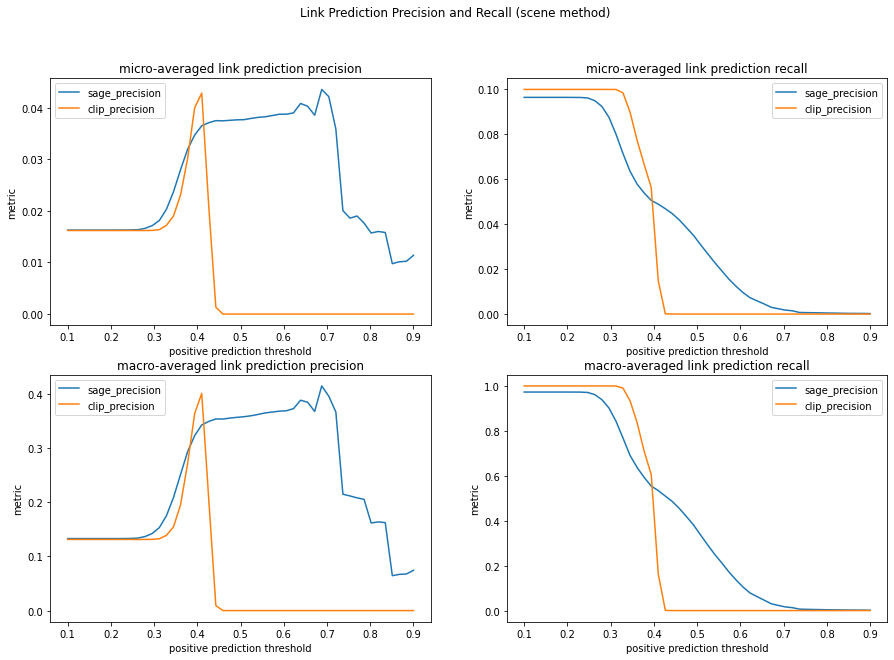

In [34]:
import matplotlib.pyplot as plt

# test_sage_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_micro', 'recall_micro']]
# test_clip_micro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='clip'][['threshold', 'precision_micro', 'recall_micro']]
# test_sage_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]
# test_clip_macro_threshold_metrics = test_sage_clip_metrics[test_sage_clip_metrics['method']=='sage'][['threshold', 'precision_macro', 'recall_macro']]

fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, avg_type in enumerate(['micro', 'macro']):
    legend = []
    for j, metric in enumerate(['precision', 'recall']):
        for method in ['sage', 'clip']:
            axs[i,j].plot(test_sage_clip_metrics[test_sage_clip_metrics['method']==method]['threshold'], 
                    test_sage_clip_metrics[test_sage_clip_metrics['method']==method][f'{metric}_{avg_type}'])
            legend += [f'{method}_{metric}']
        axs[i,j].legend(legend)
        axs[i,j].set_xlabel('positive prediction threshold')
        axs[i,j].set_ylabel('metric')
        axs[i,j].set_title(f'{avg_type}-averaged link prediction {metric}')
fig.suptitle(f'Link Prediction Precision and Recall ({reconnection_method} method)')
plt.show()


## Precision / Recall Metrics by Keyword
To render the bar graphs below, we computed precision / recall values for sage and clip at their respective best thresholds (chosen by best f1 score).

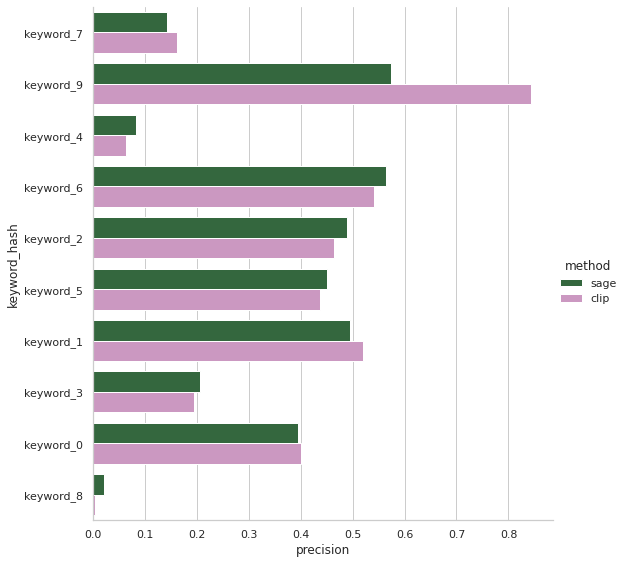

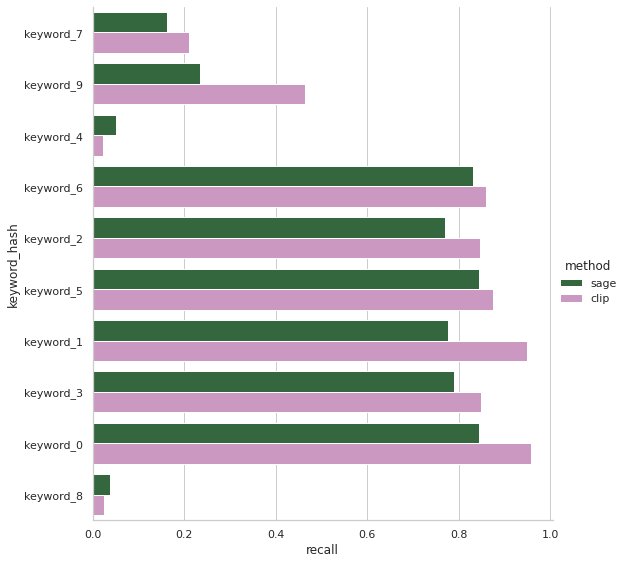

In [35]:
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.color_palette("rocket", as_cmap=True)

if not os.path.exists('prec_rec_f1_data.csv'):
    prec_rec_f1_data = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 
                                            'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
else:
    prec_rec_f1_data = pd.read_csv('prec_rec_f1_data.csv')
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!=f'sage_{reconnection_method}']
    prec_rec_f1_data = prec_rec_f1_data[prec_rec_f1_data['exp_name']!='clip']

best_sage_results_by_keyword = results_dict[best_rows['sage']['f1_macro']['threshold']]['sage']
best_clip_results_by_keyword = results_dict[best_rows['clip']['f1_macro']['threshold']]['clip']

results_by_keyword = {f'sage_{reconnection_method}': best_sage_results_by_keyword,
                      'clip': best_clip_results_by_keyword}

for exp_name in results_by_keyword:
    exp_results = pd.DataFrame(columns=['exp_name', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro'])
    exp_results['precision_macro'] = [np.mean(results_by_keyword[exp_name]['precision'])]
    exp_results['recall_macro'] = [np.mean(results_by_keyword[exp_name]['recall'])]
    exp_results['f1_macro'] = [np.mean(results_by_keyword[exp_name]['f1'])]
    exp_results['precision_micro'] = [np.mean(results_by_keyword[exp_name]['precision']*weights)]
    exp_results['recall_micro'] = [np.mean(results_by_keyword[exp_name]['recall']*weights)]
    exp_results['f1_micro'] = [np.mean(results_by_keyword[exp_name]['f1']*weights)]
    exp_results['exp_name'] = [exp_name]
    prec_rec_f1_data = pd.concat([prec_rec_f1_data, exp_results], ignore_index=True)

prec_rec_f1_data.to_csv('prec_rec_f1_data.csv', index=False)

keyword_hashes = [test_new_old_node_id_mapping[str(key.item())] for key in test_keyword_node_ids]
keyword_hashes_mask = [f'keyword_{i}' for i in range(len(keyword_hashes))]

by_keyword_results = pd.concat([pd.DataFrame({'keyword_hash': keyword_hashes_mask,
                                              'method': 'sage',
                                              'precision': best_sage_results_by_keyword['precision'],
                                              'recall': best_sage_results_by_keyword['recall'],
                                              'weights': weights}).sort_values(by='weights', ascending=False),
                                pd.DataFrame({'keyword_hash': keyword_hashes_mask,
                                              'method': 'clip',
                                              'precision': best_clip_results_by_keyword['precision'],
                                              'recall': best_clip_results_by_keyword['recall'],
                                              'weights': weights}).sort_values(by='weights', ascending=False)])

ax_prec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="precision", y="keyword_hash", hue="method",
    palette="cubehelix", height=8
)
ax_prec.set_axis_labels("precision", "keyword_hash")

ax_rec = sns.catplot(
    data=by_keyword_results, kind="bar",
    x="recall", y="keyword_hash", hue="method",
    palette="cubehelix", height=8
)

ax_rec.set_axis_labels("recall", "keyword_hash")


In [36]:
print(prec_rec_f1_data)
prec_rec_f1_data_plot = pd.melt(prec_rec_f1_data, id_vars=['exp_name'], value_vars=['precision_macro', 'recall_macro', 'f1_macro',
                                                                'precision_micro', 'recall_micro', 'f1_micro'])


      exp_name  precision_macro  recall_macro  f1_macro  precision_micro  \
0  sage_cosine         0.331477      0.530436  0.388613         0.034053   
1    sage_self         0.347032      0.524602  0.395799         0.037174   
2   sage_scene         0.342432      0.534032  0.390489         0.036468   
3         clip         0.363390      0.605616  0.422448         0.039976   

   recall_micro  f1_micro  
0      0.045786  0.038103  
1      0.049064  0.039909  
2      0.048924  0.038765  
3      0.056326  0.043235  


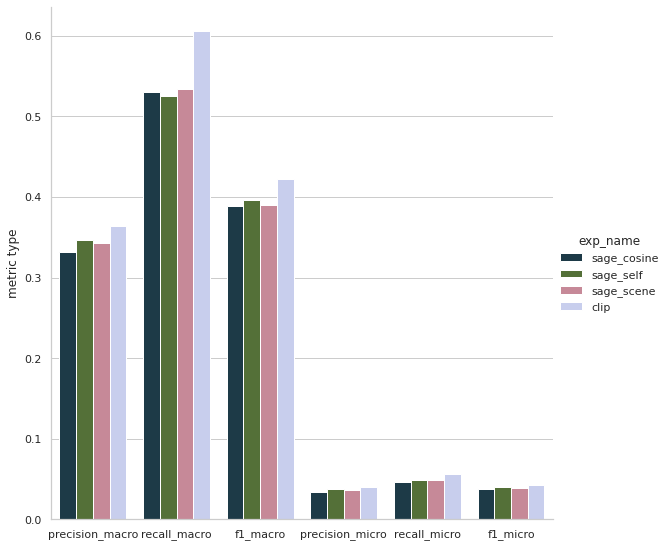

In [37]:
g_metrics = sns.catplot(
    data=prec_rec_f1_data_plot, kind="bar",
    x="variable", y="value", hue="exp_name",
    palette="cubehelix", height=8
)
#plt.title('Link Prediction Metrics At Best F1 Score')
g_metrics.set_axis_labels("", "metric type")

In [38]:
method_link_scores = {'sage': test_sage_link_scores, 'clip': test_clip_link_scores}

if not os.path.exists('roc_auc_scores.json'):
    roc_auc_values = {f'sage_{reconnection_method}': {'micro': 0, 'macro': 0}, 'clip': {'micro': 0, 'macro': 0}}
else:
    roc_auc_values = json.load(open('roc_auc_scores.json', 'r'))
    
if not os.path.exists('roc_data.csv'):
    roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
else:
    roc_data = pd.read_csv('roc_data.csv')
    roc_data = roc_data[roc_data['exp_name']!=f'sage_{reconnection_method}']
    roc_data = roc_data[roc_data['exp_name']!='clip']
     
for method in method_link_scores:
    fpr_micro, tpr_micro, thresholds = metrics.roc_curve(test_adj_matrix.flatten(), method_link_scores[method].flatten())
    method_roc_data = pd.DataFrame(columns=['exp_name', 'fpr_micro', 'tpr_micro'])
    exp_name = f'sage_{reconnection_method}' if method == 'sage' else 'clip'
    
    roc_auc_values[exp_name] = {'micro': 0, 'macro': 0} # overwrite old results
    
    method_roc_data['fpr_micro'] = fpr_micro
    method_roc_data['tpr_micro'] = tpr_micro
    method_roc_data['exp_name'] = exp_name
    
    roc_data = pd.concat([roc_data, method_roc_data])
    
    roc_auc_values[exp_name]['micro'] = metrics.auc(fpr_micro, tpr_micro)

    keyword_aucs = []
    for i in range(method_link_scores[method].shape[0]):
        keyword_aucs.append(metrics.roc_auc_score(test_adj_matrix[i], method_link_scores[method][i]))
    roc_auc_values[exp_name]['macro'] = np.mean(keyword_aucs)

#roc_data.drop_duplicates(subset='exp_name', keep='last', inplace=True)
roc_data.to_csv('roc_data.csv', index=False)
print(len(roc_data))

with open('roc_auc_scores.json', 'w') as outfile:
    json.dump(roc_auc_values, outfile)

76217


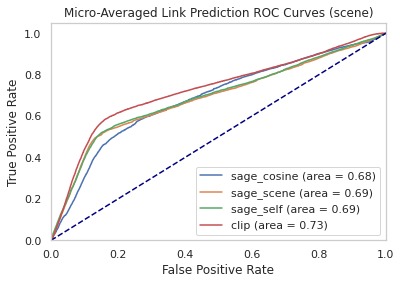

ROC AUC Scores: {'sage_scene': {'micro': 0.6858028769132436, 'macro': 0.7347276367834704}, 'clip': {'micro': 0.7259137249000747, 'macro': 0.7492239402731273}, 'sage_cosine': {'micro': 0.6845248286511094, 'macro': 0.7178712536578016}, 'sage_self': {'micro': 0.6908001678875844, 'macro': 0.7094961024261514}}


In [39]:
for exp in set(roc_data['exp_name'].values):
    exp_data = roc_data[roc_data['exp_name']==exp]
    plt.plot(exp_data['fpr_micro'], exp_data['tpr_micro'], label=f"{exp} (area = %0.2f)" % roc_auc_values[exp]['micro'])

plt.grid(False)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Micro-Averaged Link Prediction ROC Curves ({reconnection_method})")
plt.legend(loc="lower right")
plt.show()

print('ROC AUC Scores:', roc_auc_values)

In [40]:
roc_auc_values

{'sage_scene': {'micro': 0.6858028769132436, 'macro': 0.7347276367834704},
 'clip': {'micro': 0.7259137249000747, 'macro': 0.7492239402731273},
 'sage_cosine': {'micro': 0.6845248286511094, 'macro': 0.7178712536578016},
 'sage_self': {'micro': 0.6908001678875844, 'macro': 0.7094961024261514}}

In [41]:
print(test_eval_subgraph.nodes()[eval_test_keyword_node_ids])
print(eval_test_keyword_node_ids)
eval_test_img_node_ids


tensor([82737, 82740, 82800, 82802, 82809, 82925, 82926, 83039, 83103, 83801],
       device='cuda:0')
tensor([82737, 82740, 82800, 82802, 82809, 82925, 82926, 83039, 83103, 83801])


tensor([84270, 84271, 84272,  ..., 93473, 93474, 93475], device='cuda:0')

##### Additional Analysis

In [42]:
test_eval_subgraph.ndata['feat'].size()

torch.Size([93476, 512])

In [43]:
# Get one positive and negative keyword-image pair for each keyword
pos_pairs = []
neg_pairs = []
for i in range(test_adj_matrix.shape[0]):
    kw_edges = test_adj_matrix[i]
    pos_matches = kw_edges.nonzero()[0]
    neg_matches = (kw_edges==0).nonzero()[0]
    pos_pairs.append((i,np.random.choice(pos_matches, 1)[0]))
    neg_pairs.append((i,np.random.choice(neg_matches, 1)[0]))

# Get src, pos_dst, and neg_dst node IDs
node_embeds_dict = {'src': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'pos_dst': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'neg_dst': {'feat': torch.empty((len(neg_pairs), 512)), 'feat_pred': torch.empty((len(neg_pairs), 512))}}

for i in range(len(pos_pairs)):
    src_idx, pos_dst_idx = pos_pairs[i]
    _, neg_dst_idx = neg_pairs[i]
    for embed_type in ['feat', 'feat_pred']:
        node_embeds_dict['src'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_keyword_node_ids[src_idx]]
        node_embeds_dict['pos_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[pos_dst_idx]]
        node_embeds_dict['neg_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[neg_dst_idx]]



In [44]:
pos_matrix_feat = torch.cat((node_embeds_dict['src']['feat'], node_embeds_dict['pos_dst']['feat']))
pos_matrix_feat_pred = torch.cat((node_embeds_dict['src']['feat_pred'], node_embeds_dict['pos_dst']['feat_pred']))

neg_matrix_feat = torch.cat((node_embeds_dict['src']['feat'], node_embeds_dict['neg_dst']['feat']))
neg_matrix_feat_pred = torch.cat((node_embeds_dict['src']['feat_pred'], node_embeds_dict['neg_dst']['feat_pred']))

In [45]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, pair_ids, title):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(5,5))

    plt.scatter(reduced[:, 0], reduced[:, 1], c=pair_ids)
    for i, pair_id in enumerate(pair_ids):
        current_point = reduced[i]
        plt.annotate(pair_ids[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.title(title)
    plt.show()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['exp', 'legend']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


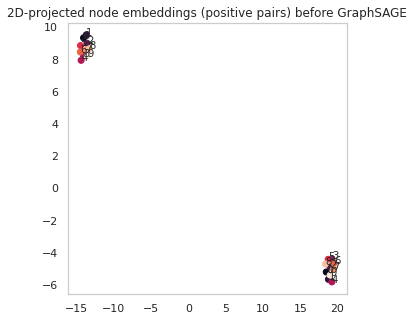

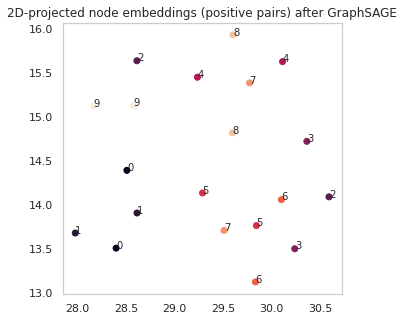

In [47]:
pair_ids = list(range(len(pos_pairs)))*2

umap_plot(pos_matrix_feat, pair_ids, title='2D-projected node embeddings (positive pairs) before GraphSAGE')
umap_plot(pos_matrix_feat_pred, pair_ids, title='2D-projected node embeddings (positive pairs) after GraphSAGE')

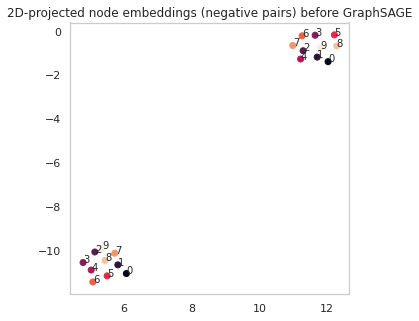

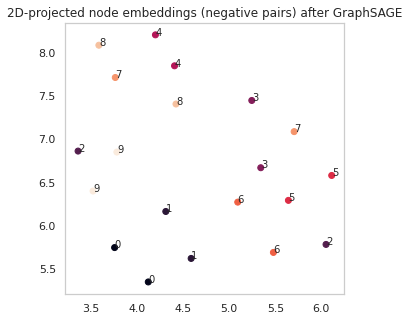

In [48]:
umap_plot(pos_matrix_feat, pair_ids, title='2D-projected node embeddings (negative pairs) before GraphSAGE')
umap_plot(pos_matrix_feat_pred, pair_ids, title='2D-projected node embeddings (negative pairs) after GraphSAGE')

In [49]:
pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

pos_sim_CLIP

array([[0.40090698, 0.40645054, 0.35292214, 0.36588883, 0.37297064,
        0.36798012, 0.36171198, 0.37642393, 0.38340783, 0.34694523],
       [0.40249503, 0.40571406, 0.3648702 , 0.36924347, 0.3685046 ,
        0.363461  , 0.3585189 , 0.38783324, 0.39227694, 0.3584776 ],
       [0.34318104, 0.34788805, 0.35515302, 0.4000777 , 0.4009665 ,
        0.40931123, 0.41354346, 0.37136236, 0.39859784, 0.35207683],
       [0.33606884, 0.3534596 , 0.36080804, 0.39275736, 0.39792344,
        0.4103744 , 0.409675  , 0.36878565, 0.3758111 , 0.3630041 ],
       [0.3128612 , 0.32567012, 0.38699946, 0.3749072 , 0.3853822 ,
        0.3401297 , 0.35105798, 0.39244124, 0.41808423, 0.37804937],
       [0.33752123, 0.35267183, 0.35862577, 0.39412582, 0.39075306,
        0.41486025, 0.4091875 , 0.36670762, 0.39035082, 0.35125563],
       [0.3192453 , 0.34382862, 0.33290502, 0.38855907, 0.38764924,
        0.40673935, 0.41781968, 0.36524594, 0.40115488, 0.3351335 ],
       [0.31634098, 0.3420525 , 0.3603049

In [50]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

for i in range(pos_sim_CLIP.shape[0]):
    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': pos_sim_CLIP[i,i],
                                                                   'non_pair_sim_CLIP': pos_sim_SAGE[i,i],
                                                                   'src_dst_sim_SAGE': pos_sim_SAGE[i,i],
                                                                   'non_pair_sim_SAGE': neg_sim_SAGE[i,i]}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pos pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['neg pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100

cos_similarities

,pair_id,src_dst_sim_CLIP,non_pair_sim_CLIP,src_dst_sim_SAGE,non_pair_sim_SAGE,pos pair similarity change,neg pair similarity change
0,0,0.400907,0.494679,0.494679,0.280931,23.389912,-43.209480
1,1,0.405714,0.645857,0.645857,0.380319,59.190243,-41.114132
2,2,0.355153,0.356189,0.356189,0.294852,0.291736,-17.220512
3,3,0.392757,0.409727,0.409727,0.366456,4.320668,-10.560875
4,4,0.385382,0.674165,0.674165,0.300394,74.934258,-55.442036
5,5,0.414860,0.590816,0.590816,0.277250,42.413265,-53.073357
6,6,0.417820,0.420321,0.420321,0.348687,0.598643,-17.042747
7,7,0.373976,0.321239,0.321239,0.492130,-14.101699,53.197567
8,8,0.384955,0.361881,0.361881,0.324346,-5.993974,-10.372131
9,9,0.392761,0.583552,0.583552,0.317062,48.577129,-45.666954


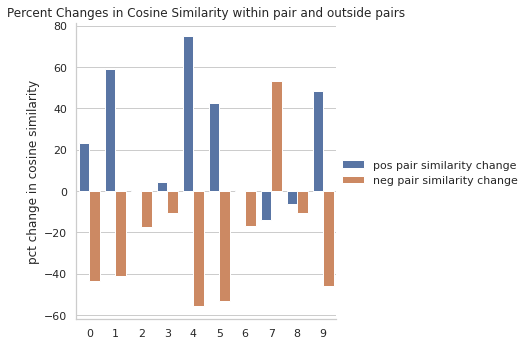

Average pair similarity change pct: 23.362019
Average non-pair similarity change pct: -24.050467


In [51]:
import seaborn as sns
sns.set_theme(style='whitegrid')
cos_similarities_tp = pd.melt(cos_similarities, id_vars='pair_id', value_vars=['pos pair similarity change', 'neg pair similarity change'])

g = sns.catplot(data=cos_similarities_tp, kind='bar', x='pair_id', y='value', hue='variable', errorbar='sd')

g.set_axis_labels('', 'pct change in cosine similarity')
g.legend.set_title('')
plt.title('Percent Changes in Cosine Similarity within pair and outside pairs')
plt.show()

print('Average pair similarity change pct:', cos_similarities['pos pair similarity change'].mean())
print('Average non-pair similarity change pct:', cos_similarities['neg pair similarity change'].mean())


In [52]:
# Get all positive and negative keyword-image pairs for each keyword
pos_pairs = []
neg_pairs = []
for i in range(test_adj_matrix.shape[0]):
    kw_edges = test_adj_matrix[i]
    pos_matches = kw_edges.nonzero()[0]
    neg_matches = np.random.choice((kw_edges==0).nonzero()[0], len(pos_matches))
    for j in range(len(pos_matches)):
        pos_pairs.append((i, pos_matches[j]))
        neg_pairs.append((i, neg_matches[j]))

# Get src, pos_dst, and neg_dst node IDs
node_embeds_dict = {'src': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'pos_dst': {'feat': torch.empty((len(pos_pairs), 512)), 'feat_pred': torch.empty((len(pos_pairs), 512))}, 
                    'neg_dst': {'feat': torch.empty((len(neg_pairs), 512)), 'feat_pred': torch.empty((len(neg_pairs), 512))}}

for i in range(len(pos_pairs)):
    src_idx, pos_dst_idx = pos_pairs[i]
    _, neg_dst_idx = neg_pairs[i]
    for embed_type in ['feat', 'feat_pred']:
        node_embeds_dict['src'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_keyword_node_ids[src_idx]]
        node_embeds_dict['pos_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[pos_dst_idx]]
        node_embeds_dict['neg_dst'][embed_type][i] = test_eval_subgraph.ndata[embed_type][eval_test_img_node_ids[neg_dst_idx]]



In [53]:
# For 10 samples, get pct change in pairwise cosine similarity for true src-dst pairs and negative pairs

import pandas as pd
from sklearn import metrics

cos_similarities = pd.DataFrame()

pos_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat'].detach().cpu().numpy())
pos_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['pos_dst']['feat_pred'].detach().cpu().numpy())

neg_sim_CLIP = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat'].detach().cpu().numpy())
neg_sim_SAGE = metrics.pairwise.cosine_similarity(node_embeds_dict['src']['feat_pred'].detach().cpu().numpy(), 
                                                  node_embeds_dict['neg_dst']['feat_pred'].detach().cpu().numpy())

for i in tqdm(range(pos_sim_CLIP.shape[0])):
    cos_similarities = pd.concat([cos_similarities, pd.DataFrame([{'pair_id': i,
                                                                   'src_dst_sim_CLIP': pos_sim_CLIP[i,i],
                                                                   'non_pair_sim_CLIP': pos_sim_SAGE[i,i],
                                                                   'src_dst_sim_SAGE': pos_sim_SAGE[i,i],
                                                                   'non_pair_sim_SAGE': neg_sim_SAGE[i,i]}])])
cos_similarities.reset_index(inplace=True, drop=True)
cos_similarities['pos pair similarity change'] = (cos_similarities['src_dst_sim_SAGE'] - cos_similarities['src_dst_sim_CLIP']) / cos_similarities['src_dst_sim_CLIP'] * 100
cos_similarities['neg pair similarity change'] = (cos_similarities['non_pair_sim_SAGE'] - cos_similarities['non_pair_sim_CLIP']) / cos_similarities['non_pair_sim_CLIP'] * 100
cos_similarities = cos_similarities[cos_similarities['neg pair similarity change']!=np.inf]

print('Average pair similarity change pct:', cos_similarities['pos pair similarity change'].mean())
print('Average non-pair similarity change pct:', cos_similarities['neg pair similarity change'].mean())

100%|██████████| 12078/12078 [00:05<00:00, 2040.16it/s]

Average pair similarity change pct: 11.849237
Average non-pair similarity change pct: -16.153574
